

# Topic modeling Diffusion of innovation - Technical

In [1]:
# Importing modules
import pandas as pd
import os
# Import the wordcloud library
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 

import seaborn as sns; sns.set_theme()
from nltk.stem.porter import PorterStemmer

import numpy as np

import matplotlib.pyplot as plt

import copy

from gensim.models import CoherenceModel


[nltk_data] Downloading package wordnet to C:\Users\Danie
[nltk_data]     Smit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Danie
[nltk_data]     Smit\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Danie
[nltk_data]     Smit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# functions
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


def get_corpus_id2word(data):
    # convert data to words
    data_words = list(sent_to_words(data))

    # remove stop words
    data_words = remove_stopwords(data_words)

    idocs = []
    for doc in data_words:
        lemmed = [WordNetLemmatizer().lemmatize(w) for w in doc]
#        stemmed = [PorterStemmer().stem(w) for w in doc]        
        idocs.append(lemmed)    
#        idocs.append(stemmed)    

    data_words = idocs
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_words)

    # Create Corpus
    texts = data_words

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return corpus, id2word, idocs

stop_words = stopwords.words('english')
stop_words.extend(['data',
                   'driven',
                   'show',
                   'get',
                   'knowledge',
                   'yes'
                   'also',
                   'give',
                   'already',
                   'etc',
                   'also',
                   'based',
                   'approach',
                   'analytics',
                   'way',
                   'ensure',
                   'line',
                   'buttom',
                   'yes',
                   'would',
                   'thing',
                   'le',
                   'increase',
                   'use',
                   'using',
                   'make',
                   'made',
                   'definitely',
                   'one',
                   'maybe',
                   'something',
                   'people',
                   'new',
#                    'training',
                   'organisation',
                   'bmw',
                   'v',
                   'create',
                   'nan',
                   'session',
                   'could',
                   'better'
                  ])


In [3]:
def do_topic_model(int_df_text, int_i_stage, int_num_topics, int_i_random_state):
    # get data
    
    if len(int_i_stage) > 0:
        data = int_df_text[int_i_stage].values.tolist()    
#         print(data)
    else:
        data = int_df_text.values.tolist()    
#         print(data)
        
    # get corpus and id2words
    corpus, id2word, lemmed = get_corpus_id2word(data)

    # Build LDA model

    # SOME_FIXED_SEED = 42

    # # before training/inference:
    # np.random.seed(SOME_FIXED_SEED)    

    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=int_num_topics,
                                           random_state=int_i_random_state)  
    # print topics
    pprint(lda_model.print_topics())
    
    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmed, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)    
    
    # save the Keyword in the 10 topics in topics
    topic = lda_model.show_topics(formatted=False)
    ifield = [int_i_stage,topic]
    topics.append(ifield)

    # Visualize the topics
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+int_i_stage+'_'+str(int_num_topics))
    # # this is a bit time consuming - make the if statement True
    # # if you want to execute visualization prep yourself
    if 1 == 1:

        LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)    

        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+int_i_stage+'_'+str(int_num_topics) +'.html')
    return LDAvis_prepared, topics


def visualize_topic_modeling(i_stage, i_topics, my_list):

    


    # populate dataframe with the weights
    ls_stage = []
    ls_topic = []
    ls_kword = []
    ls_weight = []

    # loop deur die stages, can change and improve this
    for stages in i_topics:
        if stages[0] == i_stage:
            for stage in stages[1]: 
                for topic in stage[1]:
                    ls_stage.append(stages[0])
                    ls_topic.append(stage[0])
                    ls_kword.append(topic[0])
                    ls_weight.append(topic[1]) 

    # initialise data of lists.
    data = {'Stage':ls_stage,
            'Topic':ls_topic,
            'Keyword': ls_kword,
            'Value': ls_weight}

    # Create DataFrame
    df = pd.DataFrame(data)

    df['Stage_topic'] = df['Stage'].astype(str).str[0] + df['Topic'].astype(str) 


    ls_words = df['Keyword'].unique().tolist()
    ls_stage_topic = df['Stage_topic'].unique().tolist()
    
    
    # heatmap dataframe empty
    df_heatmap = pd.DataFrame(np.array(np.zeros(len(df['Keyword'].unique()))),
                         columns=['col1'],
                         index=ls_words)

    print(df_heatmap.shape)    
    

    # populate heatmap
    for stage_topic in ls_stage_topic:

        ls_iweight = []
        for ikey in ls_words:

            ivalue = df['Value'][(df['Stage_topic']==stage_topic) & (df['Keyword'] == ikey)].values
            if len(ivalue) == 1:
                iweight = ivalue[0]
            else:
                iweight = 0 
    #         print(ikey, iweight)
            ls_iweight.append(iweight)

        df_heatmap[stage_topic] = ls_iweight
        df_heatmap

    df_heatmap = df_heatmap.drop(['col1'], axis=1)    

    # remove words that are not adding value    
    df_heatmap  = df_heatmap[~df_heatmap.index.isin(my_list)] 

    fig, ax = plt.subplots(figsize=(4,5))         # Sample figsize in inches

    cmap = copy.copy(plt.get_cmap("Blues"))
    cmap.set_under('#FFFFFF')

    sns.color_palette("Blues", as_cmap=True)
    sns.heatmap(df_heatmap, linewidths=.5, ax=ax, cmap=cmap, cbar=False, vmin=1e-5, center=1e-100);           

In [4]:
df_text = pd.read_excel(open('data/output.xlsx','rb'))# Print head
df_text.head()

,Unnamed: 0,resp_id,colle_id,start_date,end_date,ip_address,email,first_name,last_name,custom_data,...,sy_trust_to_adoption,sy_lack_trust_low_adoption,ai_transparency_to_trust,ai_accountability_to_trust,ai_fairness_to_trust,ai_trust_to_adoption,ai_lack_trust_low_adoption,ai_must_be_trans_expl,ai_ethical_considerations,ai_fat_to_trust
0,1,12897837208,404063954,2021-08-17 11:13:06,2021-08-17 12:04:29,160.48.234.77,NaN,NaN,NaN,NaN,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,4.0
1,2,12897754778,404063954,2021-08-17 10:31:55,2021-08-17 11:16:20,160.48.234.77,NaN,NaN,NaN,NaN,...,4.0,3.0,3.0,4.0,3.0,4.0,2.0,4.0,NaN,4.0
2,3,12897751825,404063954,2021-08-17 10:04:39,2021-08-17 11:13:03,160.48.234.77,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,12897749324,404063954,2021-08-17 10:03:01,2021-08-17 11:12:40,160.48.234.78,NaN,NaN,NaN,NaN,...,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,NaN,5.0
4,5,12897725977,404063954,2021-08-17 10:05:33,2021-08-17 11:00:03,160.48.234.78,NaN,NaN,NaN,NaN,...,5.0,5.0,3.0,5.0,5.0,5.0,5.0,4.0,NaN,4.0


In [5]:
list_columns = df_text.columns.to_list()
list_columns

['Unnamed: 0',
 'resp_id',
 'colle_id',
 'start_date',
 'end_date',
 'ip_address',
 'email',
 'first_name',
 'last_name',
 'custom_data',
 'consent',
 'd_tools',
 'd_capabilities',
 'd_culture',
 'd_acts_on_data',
 'd_fin_benefits',
 'd_non_fin_benefits',
 'd_agree_on_def',
 'd_def_comments',
 'm_maturity_rating',
 'm_can_improve',
 'm_how_to_improve',
 'mo_size',
 'mo_man_sup',
 'mo_org_ready',
 'mo_champion',
 'mo_scope',
 'mo_strategy_plan',
 'mo_infrastructure',
 'mo_satisfaction_exist_sys',
 'mo_fin_cost',
 'mo_perc_tech_comp',
 'mo_fin_resources',
 'mo_fin_commitment',
 'mo_fairness',
 'mo_others',
 'me_comp_press',
 'me_industry_press',
 'me_government_press',
 'me_preformance_gap',
 'me_mark_unce',
 'me_regu_envi',
 'me_regu_supp',
 'me_vendor_supp',
 'me_risk_appetite',
 'me_availibility_new_inno',
 'me_accountable',
 'me_others',
 'mt_tech_compatibility',
 'mt_tech_compexity',
 'mt_perc_barriers',
 'mt_perc_benefits',
 'mt_perc_simplicity',
 'mt_tech_competence',
 'mt_tech_in

Only keep certain columns in the dataframe:

In [6]:
columns_to_use = [
    'mt_what_doing_to_improve',
    'mt_what_can_improve',
    'how_to_confim_success',
    'adv_of_data_driven',
    'how_to_compatibility_of_tech',
    'how_to_reduce_compexity',
    'how_to_incr_trialability',
    'how_to_advant_visible',
    'what_would_prevent_usage' ]

df_text = df_text[columns_to_use]
df_text


,mt_what_doing_to_improve,mt_what_can_improve,how_to_confim_success,adv_of_data_driven,how_to_compatibility_of_tech,how_to_reduce_compexity,how_to_incr_trialability,how_to_advant_visible,what_would_prevent_usage
0,Big focus on cloud technologies and architecture.,NaN,Increase in usage of data / analytics tool. Ex...,Predictions are based on facts and figures.,Proper investigation of available technologies...,"Awareness, ""heads-up"", training and upskilling...",Maybe to pilot the system or give access to th...,Using different communication platforms...add ...,Knowledge of the system and the benefits of us...
1,SAP Analytics Cloud BW4HANA,NaN,the increase of projects being approved.,better decisions can be made,by keeping up too date and making sure the peo...,provide training,making sure the people understand the system,.,not having access to it and not understanding ...
2,NaN,NaN,Reflecting on suggestions/solutions brought ab...,Pro-activeness and solving issues before they ...,"Not sure, might depend on the technologies.",Explaining the tools and techniques simply - s...,"Yes, sandbox environments and limited free-tie...",By showing real-life examples of simple change...,Authorisation/Access and cost.
3,Various techoligies are available to accelarat...,NaN,Investigate what drives decision making (at a ...,"Competitive advantage, Ensuring that the organ...",A clear technology roadmap .is needed,"Complexity is inevitable, but a common thread ...",Access to build ad-hoc solutions.,Technology days,When I do not trust the data that is presented...
4,investing in data analytics,keep on looking,better decisions made at a strategic level. pr...,e.g. information that can be used as an advant...,proper architecture planning and long term vie...,"make it available to the users, training, ince...",buy in from the business users with real quest...,specific trails in the company to compare befo...,complexity
...,...,...,...,...,...,...,...,...,...
133,"Data lakes, business intelligence and cloud te...",NaN,Ask people difficult questions to see what the...,Better insights and better more informed decis...,Make sure that there is a central point dictat...,Provide training to understand data-driven tools.,Make it very simple to run pilot studies. Enab...,Asking questions that cannot be answered witho...,Difficulty in understanding Steep learning cu...
134,"Constant software updates, cloud training, har...",NaN,"Compare the speed, quality, efficiency, scalab...",Data is the most valuable resource on the plan...,Ensure the infrastructure being used is flexib...,Training with show and tell.,"Hmm tough one, I imagine access to sandboxes t...",Client feedback across the board should be sha...,If the system is not aligned for the work at h...
135,moving to the cloud that has more mature analy...,look at new technologies and not to get stuck ...,financial gains and being more relative in the...,knowledge over competitors. knowing what is go...,"invest more in new technologies, always try so...",having more workshops and training to make the...,having a save place to test and do POC's,having someone of a department trying new thin...,"I also try something that I don't know, so not..."
136,Highly available processes,A more robust governance framework,results in the culture,measurable decision making,ensuring a standardization in data models acr...,make stakeholders understand better,have a team for this,proper feedback system,unethical use of data


In [7]:
list_columns = df_text.columns.to_list()
list_columns

['mt_what_doing_to_improve',
 'mt_what_can_improve',
 'how_to_confim_success',
 'adv_of_data_driven',
 'how_to_compatibility_of_tech',
 'how_to_reduce_compexity',
 'how_to_incr_trialability',
 'how_to_advant_visible',
 'what_would_prevent_usage']

## Data cleaning
Remove punctuation/lower casing

In [8]:
# synomymns 
df_text = df_text.replace({'company': 'organisation'}, regex=True)
df_text = df_text.replace({'organization': 'organisation'}, regex=True)
df_text = df_text.replace({'great': 'good'}, regex=True)
df_text = df_text.replace({'mng': 'management'}, regex=True)



In [9]:
# take our special characters
for i_column in list_columns:
    df_text[i_column]      = df_text[i_column].str.replace('[^a-zA-Z0-9]', ' ').values.astype(str)    

C:\Users\DANIES~1\AppData\Local\Temp/ipykernel_29984/1835935124.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_text[i_column]      = df_text[i_column].str.replace('[^a-zA-Z0-9]', ' ').values.astype(str)


mt_what_doing_to_improve :


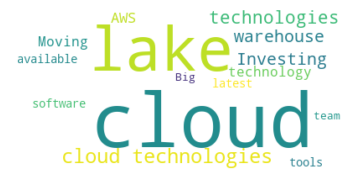

mt_what_can_improve :


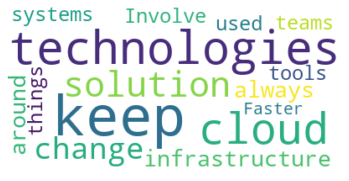

how_to_confim_success :


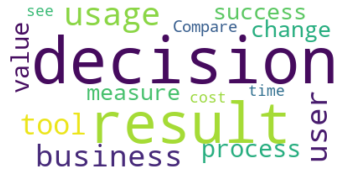

adv_of_data_driven :


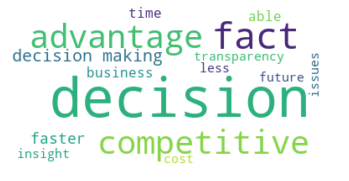

how_to_compatibility_of_tech :


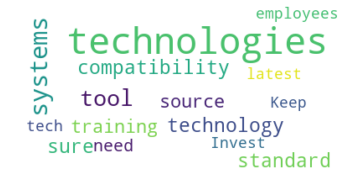

how_to_reduce_compexity :


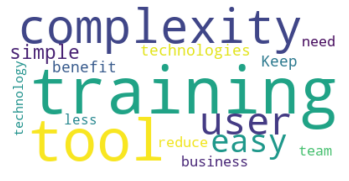

how_to_incr_trialability :


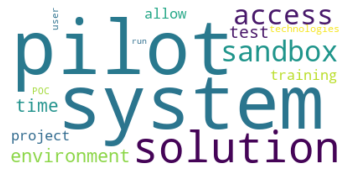

how_to_advant_visible :


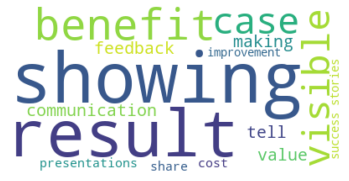

what_would_prevent_usage :


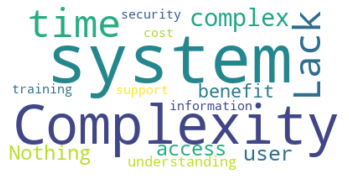

In [10]:
# print wordclouds   
for i_column in list_columns:    
    print(i_column, ':')
    # Join the different processed titles together.
    long_string = ','.join(list(df_text[i_column].values))
    # Create a WordCloud object
    wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=15, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()    
    

## Data Analysis


### What is the organisation doing at the moment to improve it data driven maturity? -> topic modeling
###  'mt_what_doing_to_improve'

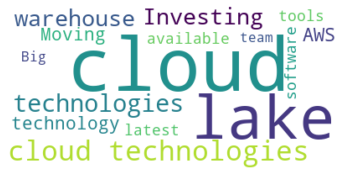

In [11]:
i_stage = 'mt_what_doing_to_improve'

# create word cloud

long_string = ','.join(list(df_text[i_stage].values))
# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=15, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()    

In [12]:
topics = []
i_random_state = 2  

num_topics = 3
LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

[(0,
  '0.027*"technology" + 0.025*"cloud" + 0.020*"place" + 0.017*"investing" + '
  '0.013*"product" + 0.012*"lake" + 0.012*"development" + 0.011*"solution" + '
  '0.011*"sure" + 0.011*"many"'),
 (1,
  '0.042*"technology" + 0.040*"cloud" + 0.040*"lake" + 0.035*"warehouse" + '
  '0.012*"available" + 0.010*"big" + 0.010*"capability" + 0.010*"benefit" + '
  '0.010*"infrastructure" + 0.010*"investment"'),
 (2,
  '0.120*"cloud" + 0.068*"technology" + 0.037*"lake" + 0.023*"investing" + '
  '0.019*"aws" + 0.018*"moving" + 0.015*"latest" + 0.011*"tech" + '
  '0.010*"public" + 0.010*"keeping"')]

Perplexity:  -5.721734626195107

Coherence Score:  0.5481705922882509


C:\ProgramData\Anaconda3\envs\data-driven-org\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


(23, 1)


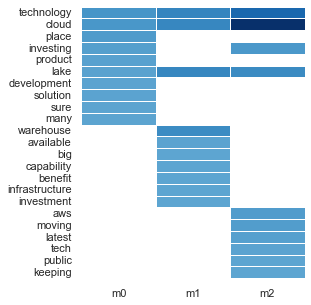

In [13]:
ex_list = ['within', 'sharing', 'within', 'idea', 'session', 'work', 'team', 'exposure', 'skill']    
visualize_topic_modeling(i_stage, topics, ex_list)

In [14]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.069323  0.028074       1        1  48.671055
1     -0.002767 -0.053034       2        1  27.009964
0      0.072090  0.024961       3        1  24.318981, topic_info=            Term       Freq      Total Category  logprob  loglift
46     warehouse   8.000000   8.000000  Default  30.0000  30.0000
91         place   2.000000   2.000000  Default  29.0000  29.0000
2          cloud  38.000000  38.000000  Default  28.0000  28.0000
85       product   3.000000   3.000000  Default  27.0000  27.0000
15          lake  16.000000  16.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
33   improvement   0.775067   1.845452   Topic3  -5.0870   0.5464
101        build   0.776408   1.966499   Topic3  -5.0853   0.4846
52   warehousing   0.779589   2.705434   Topic3  -5.0812   0.1697
3          focus   0.779009   2.653831   Topic3  -5.0819   0.1882
65     improving   0.781029   3.334893   Topic3  -5.0793  -0.0377

[179 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
26        3  0.813569       access
59        2  0.792569   accessible
79        2  0.792442       across
139       3  0.814896   additional
187       3  0.813907    algorithm
...     ...       ...          ...
52        3  0.369626  warehousing
250       1  0.722048         well
235       2  0.791608       within
154       1  0.513361      working
154       2  0.513361      working

[175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [15]:
df_text[i_stage].values

array(['Big focus on cloud technologies and architecture ',
       'SAP Analytics Cloud  BW4HANA', 'nan',
       'Various techoligies are available to accelarate a data driven approach  robust reporting capabilities  ad hoc querying  reporting  the presence of a data lake   BUT  a data lake on it s own is meaningless if a data driven culture is not driven in unison by business and IT ',
       'investing in data analytics ', 'Data is achived  ',
       'exploring and allowing access to many technologies ',
       'We now moving into AWS',
       'Constant improvement and investment in new technology ',
       'The organisation is keeping with the times i e  latest technology and tools  resources  etc ',
       'Building a team dedicated towards data and analytics',
       'They are investing more on cloud technologies ',
       'Cloud Technologies and implementing Data lake  ', 'nan', 'nan',
       'nan', 'Invest in AWS  cloud technologies  data warehouses ',
       'Moving data to the

### What is the organisation doing at the moment to improve it data driven maturity? -> topic modeling
###  'mt_what_doing_to_improve'

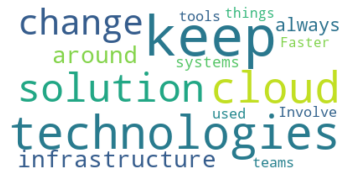

In [16]:
i_stage = 'mt_what_can_improve'

# ['mt_what_doing_to_improve',
#  'mt_what_can_improve',
#  'how_to_confim_success',
#  'adv_of_data_driven',
#  'how_to_compatibility_of_tech',
#  'how_to_reduce_compexity',
#  'how_to_incr_trialability',
#  'how_to_advant_visible',
#  'what_would_prevent_usage']

# create word cloud

long_string = ','.join(list(df_text[i_stage].values))
# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=15, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()    

In [24]:
topics = []
i_random_state = 2

num_topics = 2
LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

[(0,
  '0.021*"technology" + 0.012*"keep" + 0.010*"cloud" + 0.010*"around" + '
  '0.010*"always" + 0.009*"solution" + 0.009*"improvement" + '
  '0.009*"infrastructure" + 0.008*"team" + 0.007*"faster"'),
 (1,
  '0.016*"keep" + 0.013*"technology" + 0.012*"cloud" + 0.011*"change" + '
  '0.010*"system" + 0.010*"solution" + 0.009*"plan" + 0.008*"used" + '
  '0.008*"year" + 0.008*"invest"')]

Perplexity:  -6.181780014075531

Coherence Score:  0.5875291510919306


In [25]:
LDAvis_prepared

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.018762  0.0       1        1  54.611463
1     -0.018762  0.0       2        1  45.388537, topic_info=         Term      Freq     Total Category  logprob  loglift
8      system  2.000000  2.000000  Default  30.0000  30.0000
117     start  1.000000  1.000000  Default  29.0000  29.0000
6      regard  1.000000  1.000000  Default  28.0000  28.0000
78   everyone  1.000000  1.000000  Default  27.0000  27.0000
152      like  1.000000  1.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
229   working  0.850263  1.717167   Topic2  -5.2804   0.0870
164    always  0.972518  2.932723   Topic2  -5.1460  -0.3139
168      grow  0.846109  1.717830   Topic2  -5.2853   0.0817
39     around  0.875537  2.948159   Topic2  -5.2511  -0.4242
76     faster  0.853102  2.334215   Topic2  -5.2770  -0.2166

[141 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
170       2  0.895860            aid
24        1  0.564622          allow
24        2  0.564622          allow
164       1  0.681960         always
164       2  0.340980         always
...     ...       ...            ...
180       2  0.896745  visualization
229       1  0.582355        working
229       2  0.582355        working
63        1  0.441846           year
63        2  0.441846           year

[140 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

(16, 1)


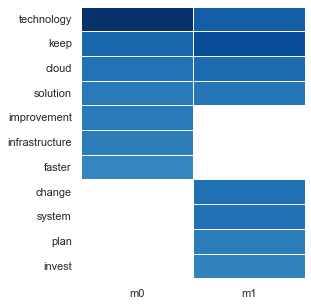

In [30]:
ex_list = ['within', 'sharing', 'within', 'idea', 'session', 'work', 'team', 'exposure', 'skill', 'around', 'year', 'always', 'used']    
visualize_topic_modeling(i_stage, topics, ex_list)

In [27]:
df_text[i_stage].values

array(['nan', 'nan', 'nan', 'nan', 'keep on looking', 'nan', 'nan', 'nan',
       'Better scheduling of downtime with regards to upgrades and change overs to improved systems ',
       'nan',
       'Involve teams more and educate them on how they can leverage data and use existing data infrastructure to deliver more value ',
       'nan', 'Streamline all the departments to cloud technologies ',
       'Reduce complexity', 'nan', 'nan', 'nan', 'nan',
       'Maybe allow for non approved corporate applications to be used in order to remove red tape and competition between applications',
       'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan',
       'Training and Implementing Analytical Tools',
       'if i can mention SAP Fiori that is a fairly young  don t want to say new  its been around for a few years already  the landscape is evolving fast around the world and we are trying to do rushed implementations but with learning on the job sometimes does not allow you to implement innovate 

In [31]:
topics

[['mt_what_can_improve',
  [(0,
    [('technology', 0.02097348),
     ('keep', 0.012101007),
     ('cloud', 0.010319477),
     ('around', 0.0103130825),
     ('always', 0.009753708),
     ('solution', 0.009177814),
     ('improvement', 0.008962661),
     ('infrastructure', 0.008682813),
     ('team', 0.0077806218),
     ('faster', 0.0073698154)]),
   (1,
    [('keep', 0.016142868),
     ('technology', 0.01331203),
     ('cloud', 0.011613498),
     ('change', 0.010634883),
     ('system', 0.0103612915),
     ('solution', 0.0096093165),
     ('plan', 0.0087570185),
     ('used', 0.008019885),
     ('year', 0.0077768792),
     ('invest', 0.0077749738)])]]]

###  relative advantage -> topic modeling
###  'adv_of_data_driven'

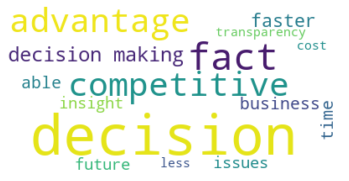

In [32]:
i_stage = 'adv_of_data_driven'

# ['mt_what_doing_to_improve',
#  'mt_what_can_improve',
#  'how_to_confim_success',
#  'adv_of_data_driven',
#  'how_to_compatibility_of_tech',
#  'how_to_reduce_compexity',
#  'how_to_incr_trialability',
#  'how_to_advant_visible',
#  'what_would_prevent_usage']

# create word cloud

long_string = ','.join(list(df_text[i_stage].values))
# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=15, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()    

In [33]:
topics = []
i_random_state = 3   # 2

num_topics = 3
LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

[(0,
  '0.029*"fact" + 0.026*"decision" + 0.013*"business" + 0.011*"issue" + '
  '0.011*"improvement" + 0.009*"advantage" + 0.009*"accurate" + 0.009*"market" '
  '+ 0.009*"informed" + 0.008*"always"'),
 (1,
  '0.023*"decision" + 0.018*"competitive" + 0.013*"information" + '
  '0.011*"quality" + 0.011*"trend" + 0.009*"process" + 0.009*"competitor" + '
  '0.009*"advantage" + 0.009*"organisational" + 0.009*"customer"'),
 (2,
  '0.080*"decision" + 0.025*"making" + 0.015*"faster" + 0.014*"advantage" + '
  '0.014*"able" + 0.013*"competitive" + 0.011*"insight" + 0.011*"future" + '
  '0.009*"quickly" + 0.008*"cost"')]

Perplexity:  -6.2925659582520685

Coherence Score:  0.6194722679061933


C:\ProgramData\Anaconda3\envs\data-driven-org\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [34]:
# topics = []
# i_random_state = 3   # 2

# num_topics = 4
# LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

In [35]:
# topics = []
# i_random_state = 3   # 2

# num_topics = 5
# LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

In [36]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.066826 -0.035302       1        1  45.450810
0     -0.075624 -0.024265       2        1  35.236295
1      0.008798  0.059568       3        1  19.312895, topic_info=              Term       Freq      Total Category  logprob  loglift
0             fact   9.000000   9.000000  Default  30.0000  30.0000
3         decision  34.000000  34.000000  Default  29.0000  29.0000
110         making   9.000000   9.000000  Default  28.0000  28.0000
11     competitive   7.000000   7.000000  Default  27.0000  27.0000
18     information   2.000000   2.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
73              le   0.748475   4.597648   Topic3  -5.1907  -0.1709
276         allows   0.702953   1.874179   Topic3  -5.2534   0.6638
96      efficiency   0.711286   2.544578   Topic3  -5.2416   0.3698
155            see   0.718838   3.831187   Topic3  -5.2311  -0.0289
141  understanding   0.705141   3.243581   Topic3  -5.2503   0.1184

[190 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
123       1  0.397733  ability
123       2  0.397733  ability
123       3  0.397733  ability
80        1  0.721054     able
80        2  0.180264     able
...     ...       ...      ...
235       2  0.780968    whole
202       2  0.781020  wildest
203       2  0.781098  willing
71        1  0.541264   within
71        3  0.541264   within

[205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

(25, 1)


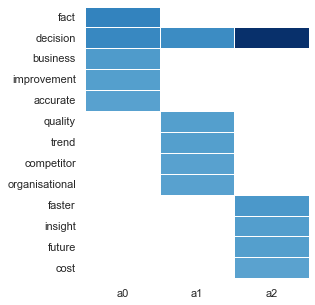

In [37]:
ex_list = ['change', 'able', 'making', 'time', 'transparency', 'le', 'issue', 'market', 'informed', 'always', 'advantage', 'competitive', 'quickly', 'process', 'information', 'customer']    
visualize_topic_modeling(i_stage, topics, ex_list)

In [38]:
topics

[['adv_of_data_driven',
  [(0,
    [('fact', 0.029044524),
     ('decision', 0.025742983),
     ('business', 0.0132269105),
     ('issue', 0.011136482),
     ('improvement', 0.010834691),
     ('advantage', 0.009411633),
     ('accurate', 0.009171799),
     ('market', 0.008553369),
     ('informed', 0.008520095),
     ('always', 0.008383172)]),
   (1,
    [('decision', 0.02340151),
     ('competitive', 0.01823187),
     ('information', 0.012586294),
     ('quality', 0.0110552665),
     ('trend', 0.010773331),
     ('process', 0.009098328),
     ('competitor', 0.009074998),
     ('advantage', 0.009059455),
     ('organisational', 0.008929109),
     ('customer', 0.008914404)]),
   (2,
    [('decision', 0.08026086),
     ('making', 0.02466537),
     ('faster', 0.015217885),
     ('advantage', 0.013939285),
     ('able', 0.013750056),
     ('competitive', 0.012975674),
     ('insight', 0.011381783),
     ('future', 0.011026084),
     ('quickly', 0.008951035),
     ('cost', 0.008352419)])]]

###  how_to_compatibility_of_tech -> topic modeling
###  'how_to_compatibility_of_tech'

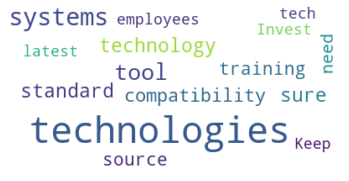

In [45]:
i_stage = 'how_to_compatibility_of_tech'

# ['mt_what_doing_to_improve',
#  'mt_what_can_improve',
#  'how_to_confim_success',
#  'adv_of_data_driven',
#  'how_to_compatibility_of_tech',
#  'how_to_reduce_compexity',
#  'how_to_incr_trialability',
#  'how_to_advant_visible',
#  'what_would_prevent_usage']

# create word cloud

long_string = ','.join(list(df_text[i_stage].values))
# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=15, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()    

In [46]:
# topics = []
# i_random_state = 3   # 3 1   not 2 4

# num_topics = 2
# LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

In [47]:
topics = []
i_random_state = 3   # 3 1   not 2 4

num_topics = 3
LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

[(0,
  '0.045*"technology" + 0.025*"system" + 0.015*"process" + 0.013*"invest" + '
  '0.013*"compatibility" + 0.011*"source" + 0.011*"used" + 0.011*"available" + '
  '0.009*"integrate" + 0.009*"tool"'),
 (1,
  '0.032*"technology" + 0.024*"standard" + 0.014*"sure" + 0.013*"making" + '
  '0.011*"training" + 0.011*"system" + 0.010*"best" + 0.010*"compatible" + '
  '0.009*"need" + 0.009*"multiple"'),
 (2,
  '0.057*"technology" + 0.019*"tool" + 0.012*"want" + 0.012*"architecture" + '
  '0.012*"strategy" + 0.011*"sure" + 0.009*"existing" + 0.009*"support" + '
  '0.009*"level" + 0.009*"training"')]

Perplexity:  -6.327261661371812

Coherence Score:  0.6182271452541733


C:\ProgramData\Anaconda3\envs\data-driven-org\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [48]:
# topics = []
# i_random_state = 3   # 3 1   not 2 4

# num_topics = 4
# LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

In [49]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.078913 -0.017432       1        1  41.872213
2      0.057475 -0.048543       2        1  30.875200
1      0.021438  0.065975       3        1  27.252587, topic_info=              Term      Freq     Total Category  logprob  loglift
92        standard  5.000000  5.000000  Default  30.0000  30.0000
10          making  3.000000  3.000000  Default  29.0000  29.0000
11            sure  5.000000  5.000000  Default  28.0000  28.0000
96            want  3.000000  3.000000  Default  27.0000  27.0000
41          system  9.000000  9.000000  Default  26.0000  26.0000
..             ...       ...       ...      ...      ...      ...
56        employee  1.171247  3.917514   Topic3  -5.0669   0.0926
177  compatibility  1.154291  5.980664   Topic3  -5.0815  -0.3450
8             date  0.880407  1.935631   Topic3  -5.3524   0.5122
102     complexity  0.925223  2.646626   Topic3  -5.3027   0.2490
84       integrate  0.914918  4.040081   Topic3  -5.3139  -0.1852

[178 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
270       2  0.548261  accepted
7         3  0.540973  accurate
18        2  0.548487   achieve
285       3  0.539273    across
33        1  0.970034     adapt
...     ...       ...       ...
275       2  0.547807    widely
172       1  0.317190      work
172       2  0.634381      work
172       3  0.317190      work
306       2  0.543628   working

[189 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

(24, 1)


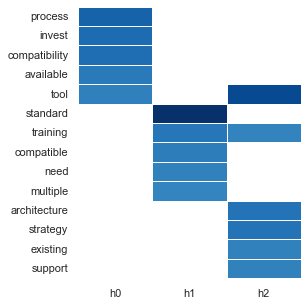

In [50]:
ex_list = ['system', 'source', 'used', 'technology', 'integrate', 'sure', 'making', 'best', 'want', 'level']    
visualize_topic_modeling(i_stage, topics, ex_list)

#  how_to_reduce_compexity -> topic modeling
###  'how_to_reduce_compexity'

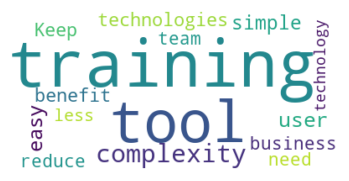

In [51]:
i_stage = 'how_to_reduce_compexity'

# ['mt_what_doing_to_improve',
#  'mt_what_can_improve',
#  'how_to_confim_success',
#  'adv_of_data_driven',
#  'how_to_compatibility_of_tech',
#  'how_to_reduce_compexity',
#  'how_to_incr_trialability',
#  'how_to_advant_visible',
#  'what_would_prevent_usage']

# create word cloud

long_string = ','.join(list(df_text[i_stage].values))
# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=15, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()    

In [52]:
# topics = []
# i_random_state = 1   # 

# num_topics = 2

# LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

In [53]:
topics = []
i_random_state = 1   # 

num_topics = 3

LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

[(0,
  '0.030*"training" + 0.019*"tool" + 0.015*"user" + 0.014*"team" + '
  '0.013*"technology" + 0.012*"process" + 0.012*"complexity" + 0.011*"session" '
  '+ 0.009*"sure" + 0.008*"experience"'),
 (1,
  '0.030*"complexity" + 0.029*"training" + 0.021*"tool" + 0.015*"technology" + '
  '0.013*"easy" + 0.011*"user" + 0.010*"business" + 0.010*"le" + '
  '0.009*"reduce" + 0.008*"perceived"'),
 (2,
  '0.023*"tool" + 0.015*"training" + 0.015*"simple" + 0.013*"keep" + '
  '0.011*"employee" + 0.009*"complex" + 0.008*"need" + 0.008*"benefit" + '
  '0.007*"demo" + 0.007*"easy"')]

Perplexity:  -6.521634170344267

Coherence Score:  0.5454239836985688


C:\ProgramData\Anaconda3\envs\data-driven-org\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [54]:
# topics = []
# i_random_state = 1   # 

# num_topics = 4

# LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

In [55]:
# topics = []
# i_random_state = 1   # 

# num_topics = 5

# LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

In [56]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.012799 -0.060563       1        1  42.602213
0     -0.061324  0.019697       2        1  32.550732
2      0.048526  0.040866       3        1  24.847054, topic_info=           Term      Freq      Total Category  logprob  loglift
86         team  5.000000   5.000000  Default  30.0000  30.0000
85      session  3.000000   3.000000  Default  29.0000  29.0000
56     employee  2.000000   2.000000  Default  28.0000  28.0000
114      simple  6.000000   6.000000  Default  27.0000  27.0000
27      process  4.000000   4.000000  Default  26.0000  26.0000
..          ...       ...        ...      ...      ...      ...
23   complexity  1.182492  13.698951   Topic3  -5.0785  -1.0573
197   education  0.838755   2.500461   Topic3  -5.4220   0.3001
49   technology  0.981597   9.060993   Topic3  -5.2647  -0.8301
93           le  0.888448   4.500078   Topic3  -5.3644  -0.2299
162         try  0.840722   3.150210   Topic3  -5.4196   0.0715

[190 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
297       3  0.833904   accessible
360       2  0.785958  aggregating
406       1  0.511234    alignment
218       1  0.410595     allowing
218       2  0.410595     allowing
...     ...       ...          ...
88        2  0.521792       within
34        1  0.773382      without
337       1  0.317307         work
337       2  0.634614         work
337       3  0.317307         work

[207 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

(22, 1)


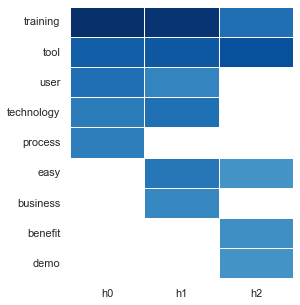

In [57]:
ex_list = ['sure', 'le', 'complexity', 'team', 'session', 'experience', 'percieved', 'reduce', 'perceived', 'keep', 'need', 'simple', 'complex', 'employee']    
visualize_topic_modeling(i_stage, topics, ex_list)

#  how_to_incr_trialability -> topic modeling
###  'how_to_incr_trialability'

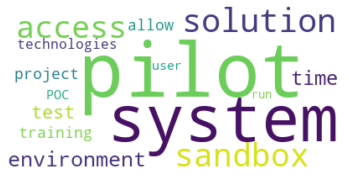

In [58]:
i_stage = 'how_to_incr_trialability'

# ['mt_what_doing_to_improve',
#  'mt_what_can_improve',
#  'how_to_confim_success',
#  'adv_of_data_driven',
#  'how_to_compatibility_of_tech',
#  'how_to_reduce_compexity',
#  'how_to_incr_trialability',
#  'how_to_advant_visible',
#  'what_would_prevent_usage']

# create word cloud

long_string = ','.join(list(df_text[i_stage].values))
# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=15, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()    

In [64]:
topics = []
i_random_state = 1   # 

num_topics = 2

LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

[(0,
  '0.013*"environment" + 0.013*"sandbox" + 0.013*"time" + 0.012*"pilot" + '
  '0.010*"technology" + 0.010*"training" + 0.009*"system" + 0.009*"access" + '
  '0.008*"solution" + 0.008*"project"'),
 (1,
  '0.026*"system" + 0.024*"pilot" + 0.017*"solution" + 0.017*"sandbox" + '
  '0.014*"access" + 0.014*"test" + 0.011*"environment" + 0.009*"time" + '
  '0.008*"user" + 0.007*"technology"')]

Perplexity:  -6.444818968244252

Coherence Score:  0.470324727769842


C:\ProgramData\Anaconda3\envs\data-driven-org\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [65]:
# topics = []
# i_random_state = 1   # 

# num_topics = 3

# LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

In [66]:
# topics = []
# i_random_state = 1   # 

# num_topics = 4

# LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

In [67]:
LDAvis_prepared

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.018612  0.0       1        1  54.690842
0     -0.018612  0.0       2        1  45.309158, topic_info=         Term       Freq      Total Category  logprob  loglift
7      system  16.000000  16.000000  Default  30.0000  30.0000
95       test   8.000000   8.000000  Default  29.0000  29.0000
40   training   5.000000   5.000000  Default  28.0000  28.0000
258  platform   3.000000   3.000000  Default  27.0000  27.0000
3       pilot  16.000000  16.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
131      play   1.789435   3.875150   Topic2  -5.3949   0.0190
29     needed   1.627976   3.229096   Topic2  -5.4895   0.1068
56        run   1.848422   4.521367   Topic2  -5.3625  -0.1028
181    within   1.568749   3.229191   Topic2  -5.5266   0.0697
95       test   1.847449   8.399494   Topic2  -5.3630  -0.7227

[150 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.677257     access
0         2  0.387004     access
280       1  0.515908        add
77        1  0.516247  advantage
77        2  0.516247  advantage
...     ...       ...        ...
181       2  0.619350     within
84        1  0.387173    without
84        2  0.774346    without
85        1  0.516217       work
85        2  0.516217       work

[168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

(12, 1)


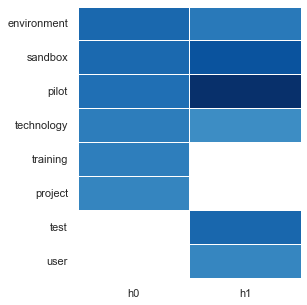

In [70]:
ex_list = ['time', 'access', 'solution', 'system']    
visualize_topic_modeling(i_stage, topics, ex_list)

#  how_to_advant_visible -> topic modeling
###  'how_to_advant_visible'

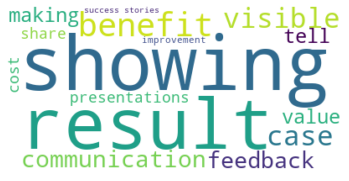

In [71]:
i_stage = 'how_to_advant_visible'

# ['mt_what_doing_to_improve',
#  'mt_what_can_improve',
#  'how_to_confim_success',
#  'adv_of_data_driven',
#  'how_to_compatibility_of_tech',
#  'how_to_reduce_compexity',
#  'how_to_incr_trialability',
#  'how_to_advant_visible',
#  'what_would_prevent_usage']

# create word cloud

long_string = ','.join(list(df_text[i_stage].values))
# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=15, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()    

In [77]:
# topics = []
# i_random_state = 1   # 

# num_topics = 2

# LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

In [78]:
topics = []
i_random_state = 1   # 

num_topics = 3

LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

[(0,
  '0.025*"showing" + 0.013*"feedback" + 0.011*"case" + 0.010*"improvement" + '
  '0.010*"communication" + 0.010*"decision" + 0.009*"visible" + 0.008*"share" '
  '+ 0.008*"benefit" + 0.007*"cost"'),
 (1,
  '0.013*"presentation" + 0.013*"training" + 0.012*"benefit" + 0.012*"tell" + '
  '0.010*"must" + 0.010*"roadshows" + 0.008*"report" + 0.007*"result" + '
  '0.007*"demo" + 0.007*"achieved"'),
 (2,
  '0.029*"result" + 0.020*"success" + 0.017*"showing" + 0.015*"story" + '
  '0.012*"case" + 0.012*"working" + 0.010*"benefit" + 0.010*"value" + '
  '0.009*"making" + 0.009*"cost"')]

Perplexity:  -6.523423837826624

Coherence Score:  0.6795452340427485


C:\ProgramData\Anaconda3\envs\data-driven-org\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [82]:
# topics = []
# i_random_state = 1   # 

# num_topics = 4

# LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)

In [83]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.076495  0.017408       1        1  35.849855
1      0.022092 -0.070523       2        1  32.957792
0      0.054403  0.053115       3        1  31.192353, topic_info=         Term      Freq     Total Category  logprob  loglift
70     result  8.000000  8.000000  Default  30.0000  30.0000
17    showing  9.000000  9.000000  Default  29.0000  29.0000
102  training  3.000000  3.000000  Default  28.0000  28.0000
31    success  6.000000  6.000000  Default  27.0000  27.0000
34   feedback  3.000000  3.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
80    visible  1.635117  4.964171   Topic3  -4.7633   0.0545
157      cost  1.397577  3.729206   Topic3  -4.9203   0.1835
54     making  1.386045  3.729643   Topic3  -4.9285   0.1751
51    benefit  1.456281  6.217783   Topic3  -4.8791  -0.2865
31    success  1.106514  6.276073   Topic3  -5.1538  -0.5705

[184 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
147       3  0.817803    access
90        1  0.322112  accurate
90        2  0.322112  accurate
90        3  0.322112  accurate
191       1  0.400426  achieved
...     ...       ...       ...
274       3  0.546246   without
275       2  0.408066      work
275       3  0.408066      work
50        1  0.951808   working
308       2  0.536901  workshop

[201 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

(24, 1)


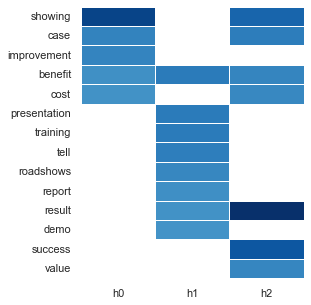

In [93]:
ex_list = ['communication', 'feedback', 'decision', 'visible', 'share', 'must', 'achieved', 'working', 'making', 'story']    
visualize_topic_modeling(i_stage, topics, ex_list)

## All

In [ ]:
i_stage = ''

# ['mt_what_doing_to_improve',
#  'mt_what_can_improve',
#  'how_to_confim_success',
#  'adv_of_data_driven',
#  'how_to_compatibility_of_tech',
#  'how_to_reduce_compexity',
#  'how_to_incr_trialability',
#  'how_to_advant_visible',
#  'what_would_prevent_usage']

# create word cloud

long_string = ','.join(list(df_text[].values))
# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=15, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()    

In [ ]:
topics = []
i_random_state = 1   # 

num_topics = 3

LDAvis_prepared, topics = do_topic_model(df_text, i_stage, num_topics, i_random_state)